#Training Neural Networks
In this lab session, we will practice the training techniques and recipes seen during the theoretical sessions. Remember that there are three main aspects you have to consider:


1.   One time setup considerations.
2.   Improve your training error.
3.   Improve your test error.

We will stick ourselves to a fixed MLP architecture and see how different training techniques impact our results, both in train and development. Finally, using all the lessons learned, we will train our MLP and check the results in the test data.

##The dataset
We will work with a dataset of images called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). In this dataset, we have images of size $32 \times 32 \times 3$, corresponding to height (H), width (W) and channels (C). Remember that coloured images use 3 channels (red-green-blue).

All the images of the dataset are classified into 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. So, our task is to build a neural network that classifies images correctly. But first of all, let's download the dataset to prepare it.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

print(f'Dataset samples: {len(training_data)}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Dataset samples: 50000


We have only downloaded training images, to have a dataset of 50 thousand images. Remember that test images cannot be used during the design and development of our neural network. However, to guide our decisions regarding hyperparameters, we will generate a **development set**. The best way to do that is to use a **stratified** partition, i.e. a random partition where we maintain the original distribution of classes. For that purpose, we use the `train_test_split()` function of scikit-learn. 

In [ ]:
# Split the indices in a stratified way
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.arange(len(training_data))
train_indices, dev_indices = train_test_split(indices, train_size=40000, stratify=training_data.targets, random_state=42)

train_set = Subset(training_data, train_indices)
dev_set = Subset(training_data, dev_indices)

print(f'Train samples: {len(train_set)}')
print(f'Dev samples: {len(dev_set)}')

Train samples: 40000
Dev samples: 10000


Check whether both sets are balanced in terms of the number of samples for each class. The following cell calculates the percentage of samples of each set for each of the labels. Remember that train and dev sets should follow the same distribution:

In [ ]:
from collections import Counter

train_counter = Counter(list(zip(*train_set))[1])
train_sorted = sorted(train_counter.items(), key = lambda kv: kv[0])
train_sorted_labels = list(zip(*train_sorted))[0]
train_percentages = np.array(list(zip(*train_sorted))[1]) / len(train_set)

dev_counter = Counter(list(zip(*dev_set))[1])
dev_sorted = sorted(dev_counter.items(), key = lambda kv: kv[0])
dev_sorted_labels = list(zip(*dev_sorted))[0]
dev_percentages = np.array(list(zip(*dev_sorted))[1]) / len(dev_set)

print(f"Train (label, %): {list(zip(train_sorted_labels, train_percentages))}")
print(f"Dev (label, %): {list(zip(dev_sorted_labels, dev_percentages))}")

Train (label, %): [(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
Dev (label, %): [(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]


As can be seen, both sets are perfectly balanced: each class represents the 10% of both sets. 

We can have a look at the images of the train set, to have an idea of what kind of problem we are facing.

**NOTE:** When using images in Pytorch, the tensors are arranged as (C, H, W), instead of the more common (H, W, C) format. Take that into account, specially for visualization.

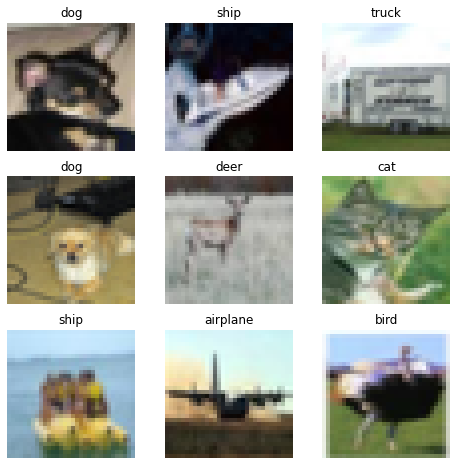

In [ ]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)) # Permute since Pytorch uses (C, H, W) and plt needs (H, W, C)
plt.show()

##The neural network
We will use a multi-layer perceptron (MLP) for this task. As we said before, we will not change the architecture of the model, as we are not interested on architectural decisions for now (how many layers? How many neurons in each layer?).

**EXERCISE:** Design a multi-layer perceptron (MLP) with the following architecture: INPUT -> LINEAR(512) -> ReLU -> LINEAR(512) -> ReLU -> LINEAR(10)

**NOTE:** Remember that images are tensors of shape (3, 32, 32) and the input for a linear layer should be a vector (in this case of size $3\times 32 \times 32 = 3072$).

**TODO:** Decide where and how to explain the issue about the absence of an activation function in the output layer and the Pytorch CrossEntropyLoss (softmax + NLL loss).

In [ ]:
# For reproducibility
torch.manual_seed(0)

class MyMLP(nn.Module):
    def __init__(self):
      super(MyMLP, self).__init__()
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(3072, 512)
      self.relu = nn.ReLU()
      self.linear2 = nn.Linear(512, 512)
      self.linear3 = nn.Linear(512, 10)

    def forward(self, x):
      x = self.flatten(x)
      logits = self.linear1(x)
      logits = self.relu(logits)
      logits = self.linear2(logits)
      logits = self.relu(logits)
      logits = self.linear3(logits)

      return logits

model = MyMLP()

# Print the number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1841162


Your MLP should have 1,841,162 learnable parameters, i.e. slightly above 1.8M parameters. 

During the set-up of a neural network, many training processes have to be performed, so training time becomes an essential part of the problem. To speed-up our training processes, we will use a GPU availabe in Colab. The following cell assigns `cuda` to the variable `device` if a GPU is available.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = model.to(device)
print(model)

Using cuda device
MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
)


We will also define the base train and test functions to use through the lab. Here you have the implementation of the functions `train_loop()` and `test_loop()`. Some details to highlight here: 

1.   Notice how we use `model.train()` and `model.eval()`. This is very important. As model behaviour during training and testing may be different (due to batch normalization and dropout, for example), Pytorch needs to know the "mode" in which we are using the model. It is also important as Pytorch does not store the gradients in `eval` mode, making calculations faster. Thus, when training, set `model.train()` and when testing, set `model.eval()`. 
2.   The function `test_loop` will be used for both development and test data. The process is the same for both datasets. The only thing that changes is the dataset itself. 

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):        
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
        
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Store loss and accuracy
      train_loss += loss.item()
      train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_acc /= size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc

##One time setup considerations
During the theoretical sessions, we saw that this step is to decide about activation functions, data preprocessing, weight initialization and batch normalization. Given the time constraints we have for the lab, we will not explore different activation functions. ReLU is our choice for all the layers. Similarly, regarding data preprocessing, we wil only scale the pixel values of the images from [0, 255] to [0, 1], and discard futher exploration. But we will skim through weight initialization and batch normalization.

###Weight initialization
When we use `torch.nn.Linear()`, Pytorch uses Xavier initialization by default. Hence, our `MyMLP` model is configured to use that initialization. Let's train it for 10 epochs to see the results we obtain in train.

**EXERCISE:** Fill in the gaps following the comments.

In [ ]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

# instantiate a MLP object in the model variable
model = MyMLP()

model = model.to(device)


# create train_dataloader
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)


# instantiate a cross-entropy loss in the loss_fn variable
loss_fn = nn.CrossEntropyLoss()
# instantiate a SGD optimizer in the optimizer variable
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.321399  [    0/40000]
loss: 2.298675  [ 6400/40000]
loss: 2.301313  [12800/40000]
loss: 2.291584  [19200/40000]
loss: 2.285453  [25600/40000]
loss: 2.281800  [32000/40000]
loss: 2.256744  [38400/40000]
train loss: 2.289400284957886, train_acc: 0.123825
Epoch 2
-------------------------------
loss: 2.277507  [    0/40000]
loss: 2.264313  [ 6400/40000]
loss: 2.270339  [12800/40000]
loss: 2.260579  [19200/40000]
loss: 2.257062  [25600/40000]
loss: 2.260245  [32000/40000]
loss: 2.251670  [38400/40000]
train loss: 2.2621935131072997, train_acc: 0.15635
Epoch 3
-------------------------------
loss: 2.237804  [    0/40000]
loss: 2.255041  [ 6400/40000]
loss: 2.249975  [12800/40000]
loss: 2.224666  [19200/40000]
loss: 2.217215  [25600/40000]
loss: 2.178922  [32000/40000]
loss: 2.193448  [38400/40000]
train loss: 2.2293982357025146, train_acc: 0.204175
Epoch 4
-------------------------------
loss: 2.155501  [    0/40000]
loss: 2.196642  [ 6400/400

Our training accuracy is 0.299, very close to 0.3.

We know from our theoretical sessions that when using ReLU activation function, He or Kaiming initialization should work better. Let's test it. We will implement a new class called `MyMLPKaiming` to apply He initialization to its linear layers. But we will keep the initial MLP architecture unchanged.

**EXERCISE:** use `torch.nn.init.kaiming_uniform_` to re-initialize the weights of the linear layers.

In [ ]:
class MyMLPKaiming(nn.Module):
    def __init__(self):
      super(MyMLPKaiming, self).__init__()
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(3*32*32, 512)
      nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='relu')

      self.linear2 = nn.Linear(512, 512)
      nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

      self.linear3 = nn.Linear(512, 10)
      nn.init.kaiming_uniform_(self.linear3.weight, mode='fan_in', nonlinearity='relu')

      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.flatten(x)
      logits = self.linear1(x)
      logits = self.relu(logits)
      logits = self.linear2(logits)
      logits = self.relu(logits)
      logits = self.linear3(logits)

      return logits

We will train the new model just as before, to compare the results fairly.

**EXERCISE:** Fill in the gaps following the comments.

In [ ]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

# instantiate a MLPKaiming object in the model variable
model = MyMLPKaiming()
model = model.to(device)


# create train_dataloader
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)



# instantiate a cross-entropy loss in the loss_fn variable
loss_fn = nn.CrossEntropyLoss()
# instantiate a SGD optimizer in the optimizer variable
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.576493  [    0/40000]
loss: 2.255191  [ 6400/40000]
loss: 2.205885  [12800/40000]
loss: 2.031555  [19200/40000]
loss: 2.023610  [25600/40000]
loss: 1.996216  [32000/40000]
loss: 2.081941  [38400/40000]
train loss: 2.1373119636535645, train_acc: 0.233575
Epoch 2
-------------------------------
loss: 2.011819  [    0/40000]
loss: 1.993810  [ 6400/40000]
loss: 1.874771  [12800/40000]
loss: 2.086034  [19200/40000]
loss: 1.822790  [25600/40000]
loss: 1.978346  [32000/40000]
loss: 1.960433  [38400/40000]
train loss: 1.9692356962203978, train_acc: 0.311925
Epoch 3
-------------------------------
loss: 2.000031  [    0/40000]
loss: 1.899098  [ 6400/40000]
loss: 2.051569  [12800/40000]
loss: 1.907200  [19200/40000]
loss: 1.868016  [25600/40000]
loss: 1.974382  [32000/40000]
loss: 2.028292  [38400/40000]
train loss: 1.897565640449524, train_acc: 0.339
Epoch 4
-------------------------------
loss: 1.971719  [    0/40000]
loss: 1.899888  [ 6400/40000

This is quite a big improvement! When linear layers were initialized with Xavier initialization, we had a training accuracy of 0.29. Now, with He initialization, we achieve 0.40. So far, we have seen that using He initialization our optimization improves faster in 10 epochs.

###Batch normalization
To implement batch normalization, we have to create another class. We will name it `MyMLPBN`. Remember that batch normalization normalizes activations with learned means and variances on mini-batches. 

**EXERCISE:** implement the necessary code to apply batch normalization to our MLP, both in the `__init__` and `forward` functions. Create 2 batch normalization layers, as much as hidden layers we have in the network, and apply them correctly in the forward pass.

In [ ]:
class MyMLPBN(nn.Module):
    def __init__(self):
      super(MyMLPBN, self).__init__()
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(3*32*32, 512)
      torch.nn.init.kaiming_uniform_(self.linear1.weight)
      self.linear1_bn = nn.BatchNorm1d(512)

      self.linear2 = nn.Linear(512, 512)
      torch.nn.init.kaiming_uniform_(self.linear2.weight)
      self.linear2_bn = nn.BatchNorm1d(512)
      self.relu = nn.ReLU()

      self.linear3 = nn.Linear(512, 10)
      torch.nn.init.kaiming_uniform_(self.linear3.weight)      

    def forward(self, x):
      x = self.flatten(x)
      logits = self.linear1(x)
      logits =  self.linear1_bn(logits)
      logits = self.relu(logits)
      logits = self.linear2(logits)
      logits =  self.linear2_bn(logits)
      logits = self.relu(logits)
      logits = self.linear3(logits)

      return logits

We are ready to train this new model with batch normalization. Again, we will use the same setting as the previous experiments, to fairly compare the obtained results.

**EXERCISE:** fill in the gaps following the comments.

In [ ]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

# instantiate a MyMLPBN object in the variable model
model = MyMLPBN()
model = model.to(device)

# create train_dataloader
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)

# instantiate a cross-entropy loss in the loss_fn variable
loss_fn = nn.CrossEntropyLoss()
# instantiate a SGD optimizer in the optimizer variable
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 2.345899  [ 6400/40000]
loss: 2.114495  [12800/40000]
loss: 1.980695  [19200/40000]
loss: 1.765399  [25600/40000]
loss: 1.882576  [32000/40000]
loss: 1.945652  [38400/40000]
train loss: 2.0921828987121582, train_acc: 0.2583
Epoch 2
-------------------------------
loss: 1.961039  [    0/40000]
loss: 1.781703  [ 6400/40000]
loss: 1.574205  [12800/40000]
loss: 2.086886  [19200/40000]
loss: 1.637454  [25600/40000]
loss: 1.831735  [32000/40000]
loss: 1.857150  [38400/40000]
train loss: 1.8189907167434693, train_acc: 0.35715
Epoch 3
-------------------------------
loss: 1.951620  [    0/40000]
loss: 1.767130  [ 6400/40000]
loss: 1.831410  [12800/40000]
loss: 1.731973  [19200/40000]
loss: 1.642663  [25600/40000]
loss: 1.747823  [32000/40000]
loss: 1.764001  [38400/40000]
train loss: 1.7245716659545898, train_acc: 0.39345
Epoch 4
-------------------------------
loss: 1.812390  [    0/40000]
loss: 1.683945  [ 6400/40000

We got another big boost here! Train accuracy is around 0.48, showing that batch normalization helps a lot in the training process. Notice that batch normalization usually allows increasing the learning rate to speed-up optimization, so let's try it. We will increase the learning rate ten times to check what happens. 

In [ ]:
import time

learning_rate = 1e-2 # New learning rate
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 1.871529  [ 6400/40000]
loss: 1.615286  [12800/40000]
loss: 1.601233  [19200/40000]
loss: 1.438730  [25600/40000]
loss: 1.508677  [32000/40000]
loss: 1.681681  [38400/40000]
train loss: 1.7351202632904053, train_acc: 0.386175
Epoch 2
-------------------------------
loss: 1.673471  [    0/40000]
loss: 1.472232  [ 6400/40000]
loss: 1.237097  [12800/40000]
loss: 1.645487  [19200/40000]
loss: 1.382110  [25600/40000]
loss: 1.435351  [32000/40000]
loss: 1.397564  [38400/40000]
train loss: 1.4826960027694702, train_acc: 0.48055
Epoch 3
-------------------------------
loss: 1.479679  [    0/40000]
loss: 1.390892  [ 6400/40000]
loss: 1.483419  [12800/40000]
loss: 1.385492  [19200/40000]
loss: 1.284133  [25600/40000]
loss: 1.385138  [32000/40000]
loss: 1.421449  [38400/40000]
train loss: 1.374046925354004, train_acc: 0.520675
Epoch 4
-------------------------------
loss: 1.286271  [    0/40000]
loss: 1.467597  [ 6400/400

Just increasing the learning rate to $10^{-2}$, we obtain 0.67 of accuracy in train. As can be seen, the impact of hyperparameters such as learning rate and techniques such as batch normalization can be very significant in the training process of a neural network.

##Improve your training error
Now that one time setup considerations are clear for us, we will explore optimizers and schedulers to improve our training performance even more.

###SGD with momentum
Keeping the same configuration as before, we will test how SGD with momentum works. 

**EXERCISE:** Substitute the SGD optimizer by SGD with momentum and use a momentum value of 0.9.

In [ ]:
import time

learning_rate = 1e-2
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 1.745602  [ 6400/40000]
loss: 1.505604  [12800/40000]
loss: 1.618249  [19200/40000]
loss: 1.452555  [25600/40000]
loss: 1.488043  [32000/40000]
loss: 1.672304  [38400/40000]
train loss: 1.6713283014297486, train_acc: 0.40905
Epoch 2
-------------------------------
loss: 1.594308  [    0/40000]
loss: 1.316226  [ 6400/40000]
loss: 1.333772  [12800/40000]
loss: 1.609985  [19200/40000]
loss: 1.293670  [25600/40000]
loss: 1.309060  [32000/40000]
loss: 1.210826  [38400/40000]
train loss: 1.4236928086280822, train_acc: 0.49335
Epoch 3
-------------------------------
loss: 1.502069  [    0/40000]
loss: 1.276432  [ 6400/40000]
loss: 1.534292  [12800/40000]
loss: 1.270739  [19200/40000]
loss: 1.151525  [25600/40000]
loss: 1.347584  [32000/40000]
loss: 1.417330  [38400/40000]
train loss: 1.2955830062866212, train_acc: 0.5399
Epoch 4
-------------------------------
loss: 1.199123  [    0/40000]
loss: 1.323167  [ 6400/40000

We keep on improving! You should have an accuracy of 0.73, which shows that SGD with momentum steps faster towards the global minimum than vanilla mini-batch gradient descent.

###Adam
We will skip RMSProp and use the Adam optimizer directly, which is usually the *de facto* standard in deep learning. Adam usually benefits from smaller learning rates, so we will decrease it to $10^{-4}$.

**EXERCISE:** use Adam with default parameter values.

In [ ]:
import time

learning_rate = 1e-4 # Decrease the learning rate
batch_size = 64
epochs = 10

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 1.810218  [ 6400/40000]
loss: 1.538449  [12800/40000]
loss: 1.541885  [19200/40000]
loss: 1.408666  [25600/40000]
loss: 1.488074  [32000/40000]
loss: 1.639456  [38400/40000]
train loss: 1.6729518020629883, train_acc: 0.4125
Epoch 2
-------------------------------
loss: 1.552140  [    0/40000]
loss: 1.356066  [ 6400/40000]
loss: 1.284702  [12800/40000]
loss: 1.621797  [19200/40000]
loss: 1.321322  [25600/40000]
loss: 1.304420  [32000/40000]
loss: 1.272212  [38400/40000]
train loss: 1.4105005314826966, train_acc: 0.505225
Epoch 3
-------------------------------
loss: 1.373138  [    0/40000]
loss: 1.277865  [ 6400/40000]
loss: 1.374313  [12800/40000]
loss: 1.344787  [19200/40000]
loss: 1.213401  [25600/40000]
loss: 1.311934  [32000/40000]
loss: 1.270326  [38400/40000]
train loss: 1.2881783643722535, train_acc: 0.550975
Epoch 4
-------------------------------
loss: 1.196358  [    0/40000]
loss: 1.312873  [ 6400/400

Well, we obtain a very similar train accuracy with Adam, i.e. around 0.73. Although it would be better to explore learning rate values more exhaustively (random search), let's stick to Adam with lr=1e-4 and train for more epochs, as the training accuracy is still improving. In the following cell you have the code to train our model for **30 epochs more** with the Adam optimizer, up to a total of 40 epochs. Look carefully at the code: as the state of `model` and `optimizer` are still stored in the session of Colab, we can resume the training process from the last epoch (epoch number 10).

In [ ]:
import time

start_epoch = 10 # Resume from the last training point
epochs = 30 # Add more epochs to our training
start = time.time()
for t in range(start_epoch, start_epoch+epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 11
-------------------------------
loss: 0.622193  [    0/40000]
loss: 0.738723  [ 6400/40000]
loss: 0.617285  [12800/40000]
loss: 0.775634  [19200/40000]
loss: 0.777743  [25600/40000]
loss: 0.947315  [32000/40000]
loss: 0.948309  [38400/40000]
train loss: 0.7544095659255982, train_acc: 0.75245
Epoch 12
-------------------------------
loss: 0.840802  [    0/40000]
loss: 0.599306  [ 6400/40000]
loss: 0.837370  [12800/40000]
loss: 0.597579  [19200/40000]
loss: 0.833388  [25600/40000]
loss: 0.769967  [32000/40000]
loss: 0.863696  [38400/40000]
train loss: 0.7040151552677154, train_acc: 0.772975
Epoch 13
-------------------------------
loss: 0.501136  [    0/40000]
loss: 0.684153  [ 6400/40000]
loss: 0.605208  [12800/40000]
loss: 0.699424  [19200/40000]
loss: 0.807079  [25600/40000]
loss: 0.822349  [32000/40000]
loss: 0.715560  [38400/40000]
train loss: 0.6557228041172027, train_acc: 0.79005
Epoch 14
-------------------------------
loss: 0.608105  [    0/40000]
loss: 0.543675  [ 6400

Wow! We achieve **0.96 accuracy** in training (very-very close to 0.97). Let me remember that the frist trial we made with the same neural network architecture achieved 0.29 accuracy. Thus, changing weight initialization, including batch normalization, tweaking a bit the learning rate, using Adam and increasing the epochs, we have now 0.96 accuracy. So **deep learning is not just about adding layers and neurons**. There are many techniques and approaches that can dramatically change the behaviour of the same neural network.

To have a better idea of how the training process went, let's look at training learning curves for loss and accuracy.

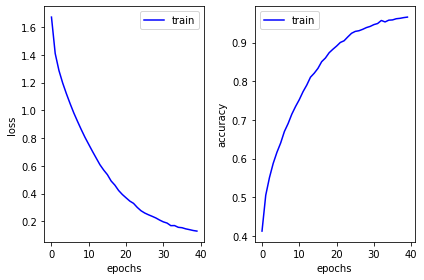

In [ ]:
import matplotlib.pyplot as plt

epochs = start_epoch + epochs
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

It seems those final epochs were a little bit oscillating, but our overall performance is great already. 

###Learning rate schedulers
From the learning curves above, we can guess the optimizer might be wandering around the global minimum. We could improve a little bit more if we use some learning rate scheduler. For that, we have to change our training function. Notice that now we pass a `scheduler` to our new function. In the body of the function, it is enough to add a `scheduler.step()` call in the suitable position, just after processing a complete epoch. 

In [ ]:
def train_loop_scheduler(dataloader, model, loss_fn, optimizer, scheduler, device):        
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

      #X = F.interpolate(X, size=32)
      X = X.to(device)
      y = y.to(device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
        
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Store loss and accuracy
      train_loss += loss.item()
      train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    scheduler.step() # Calculate the new learning rate for the next epoch
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

Now we can use any scheduler from the [long list of Pytorch](https://pytorch.org/docs/stable/optim.html). For this example, we will use the cosine scheduler. 

**EXERCISE:** write the code to use a cosine scheduler with our new function `train_loop_scheduler()`.

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 40

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

train_losses, train_accuracies  = [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # call to the new training function with the scheduler and store the returned values
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)

    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)    
end = time.time()
print("Done!")
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 1.810218  [ 6400/40000]
loss: 1.538449  [12800/40000]
loss: 1.541885  [19200/40000]
loss: 1.408666  [25600/40000]
loss: 1.488074  [32000/40000]
loss: 1.639456  [38400/40000]
train loss: 1.6729518020629883, train_acc: 0.4125
Epoch 2
-------------------------------
loss: 1.552140  [    0/40000]
loss: 1.352982  [ 6400/40000]
loss: 1.302377  [12800/40000]
loss: 1.624085  [19200/40000]
loss: 1.307402  [25600/40000]
loss: 1.286090  [32000/40000]
loss: 1.280512  [38400/40000]
train loss: 1.4098610116958619, train_acc: 0.5057
Epoch 3
-------------------------------
loss: 1.369732  [    0/40000]
loss: 1.266218  [ 6400/40000]
loss: 1.358200  [12800/40000]
loss: 1.340324  [19200/40000]
loss: 1.203812  [25600/40000]
loss: 1.311342  [32000/40000]
loss: 1.259836  [38400/40000]
train loss: 1.2892048563957215, train_acc: 0.551925
Epoch 4
-------------------------------
loss: 1.153481  [    0/40000]
loss: 1.304113  [ 6400/40000

The train accuracy improved further with a best value of 0.983. Let's look at the training curves:

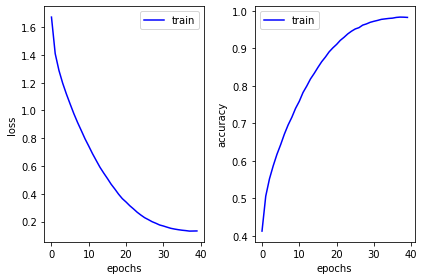

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

We will stop here, as we already have a very good training regime. To sum up, this is our current configuration:


*   Data preprocessing: scale pixel values between 0 and 1 (we did not explore this).
*   Weight initialization: He.
*   Batch normalization: yes.
*   Batch size: 64 (we did not explore this hyperparameter).
*   Learning rate (initial): 1e-4.
*   Epochs: 40.
*   Optimizer: Adam.
*   Scheduler: Cosine (we did not test other schedulers).

Our best training accuracy is 0.98.

Let's save our best trained model in the disk, just in case.

**EXERCISE:** write the code to save the trained model under the name of *model.pth*.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'model.pth'
path = F"/content/gdrive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Improve your test error
Although our training accuracy is very good and we should be satisfied, the most important performance metric is accuracy for new, unseen samples. We will estimate such performance using our development set. 

**EXERCISE:** write the code to load the previously saved Pytorch model called *model.pth* into the `model` variable.

In [ ]:
model.load_state_dict(torch.load(path))


<All keys matched successfully>

**EXERCISE:** write the code to create `dev_dataloader` from `dev_set`. Do not shuffle the data for development, as it is only to check the performance. Write also de code to call to `test_loop` and obtain `dev_loss` and `dev_acc`.

In [ ]:
dev_dataloader = DataLoader(dev_set,batch_size)
dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
"""
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_acc /= size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc"""
########################

print(f'dev loss: {dev_loss}, dev accuracy: {dev_acc}')

Test Error: 
 Accuracy: 54.2%, Avg loss: 1.648208 

dev loss: 1.6482075832451983, dev accuracy: 0.5416


Our model is clearly overfitting! It obtains 0.54 accuracy for new data, when training accuracy was 0.98. We need some regularization here. But first of all, we have to check learning curves also for development data, to have a better diagnose. To reduce training time, we will only train for 20 epochs, as it is enough to have a clear idea of what is going on:

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 20

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")
print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.817509  [    0/40000]
loss: 1.810218  [ 6400/40000]
loss: 1.538449  [12800/40000]
loss: 1.541885  [19200/40000]
loss: 1.408666  [25600/40000]
loss: 1.488074  [32000/40000]
loss: 1.639456  [38400/40000]
train loss: 1.6729518020629883, train_acc: 0.4125
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.546681 

Epoch 2
-------------------------------
loss: 1.523000  [    0/40000]
loss: 1.816629  [ 6400/40000]
loss: 1.473076  [12800/40000]
loss: 1.500469  [19200/40000]
loss: 1.328741  [25600/40000]
loss: 1.523757  [32000/40000]
loss: 1.345215  [38400/40000]
train loss: 1.4091113867759704, train_acc: 0.506725
Test Error: 
 Accuracy: 48.9%, Avg loss: 1.467902 

Epoch 3
-------------------------------
loss: 1.331209  [    0/40000]
loss: 1.411134  [ 6400/40000]
loss: 1.184598  [12800/40000]
loss: 1.297385  [19200/40000]
loss: 1.269835  [25600/40000]
loss: 1.475968  [32000/40000]
loss: 1.304483  [38400/40000]
train loss: 1.288541773891449, train_acc: 0.

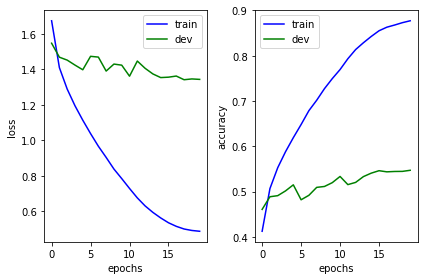

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='train')
plt.plot(range(epochs), dev_losses, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='train')
plt.plot(range(epochs), dev_accuracies, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The development performance plateaus very early in the training process. That means that the features learned during the training phase do not help for development (new) data. Our network is learning irrelevant features for the problem. We have to attack that problem now, and our weapons are regularization techniques.

###Data augmentation
Data augmentation is always a good idea and it is specially well suited for images. In Pytorch, using the torchvision library, it is remarkably easy to implement data augmentation pipelines. You can have a look [here](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) to see the available transformations and their effects.

**EXERCISE:** Using `transforms.Compose`, build the data augmentation pipeline in the variable `our_transforms`. Use the following transforms for the pipeline: random horizontal flip (probability of 0.5), color jitter (default parameters), random crop (size $28 \times 28$) and random invert (probability of 0.5).

**NOTE FOR THE EXERCISE:** after applying a random crop, your image will become of size $28 \times 28$. Check what you should do to restore its previous size.

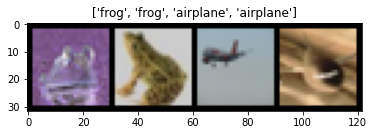

In [ ]:
import torchvision

our_transforms = transforms.Compose([
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.ColorJitter(),
                    torchvision.transforms.RandomCrop(size=(28,28)),
                    torchvision.transforms.RandomInvert(p=0.5),
                    torchvision.transforms.ToTensor()])

# Add the transforms to our dataset
# NOTE: From now on, train_set will always have these transforms
train_set.dataset.transform = our_transforms 

# Let's visualize some images
train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
imgs, labels = next(iter(train_dataloader)) # We have a batch of 4 images and labels

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Make a grid from batch
out = torchvision.utils.make_grid(imgs)

imshow(out, title=[labels_map[x.item()] for x in labels])



Data augmentation, and all the other regularization techniques, make training more difficult, so we will need more epochs to obtain good results. However, increasing the number of epochs we also increase the training time, which is a problem for this lab. For that reason, we will restrict ourselves to 20 epochs of training and try to gain intuition looking at learning curves, and comparing regularization techniques on this basis. So, please, analyse the obtained results into this context. And be patient, since the following experiments needs around **6 minutes** to be completed.

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 20 # Restrict epochs to reduce training time

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='train')
plt.plot(range(epochs), dev_losses, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='train')
plt.plot(range(epochs), dev_accuracies, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Learning curves are completely different now. Training and dev metrics are going together, which means that training performance is transferring to development performance. However, as can be seen, the best training accuracy (\~0.50) is very far from the accuracies we obtained without data augmentation (\~0.98). That means that training is now much harder, as the model is processing different images in each epoch. But our objective is to improve the performance in new images, i.e. dev accuracy. The best dev accuracy is 0.50, close to what we obtained with the previous model. Take into account that we trained only for 20 epochs now. And if we look at the curves, it seems our model could keep improving. Also you can try different transformations, besides the ones used here, and see what combination works better for this problem.

###Weight decay
Another regularization technique we saw is **weight decay**. More concretely, we will use $L2$ regularization, specifying a value for the hyperparameter $\lambda$. 

**EXERCISE:** Modify the code below to include weight decay in our training process (expected training time around **6 minutes**). 

**HINT:** In Pytorch, weight decay has to be added in the optimizer.

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 20
weight_decay = 1e-3

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
### WRITE YOUR CODE HERE ### (≈ 1 line)

########################
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Using only data augmentation, we obtained 0.5 best dev accuracy. Now, we get 0.504, which is a slight improvement. Different values for $\lambda$ should be tested, using random search, for example. However, I would not expect big improvements with weight decay in this specific problem. In any case, let's see the learning curves.

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='train')
plt.plot(range(epochs), dev_losses, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='train')
plt.plot(range(epochs), dev_accuracies, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Again, we can see that train and dev metrics are going together, which is  good.

###Dropout
We will try to use dropout. There are still some [discussions](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) regarding batch normalization and dropout. It is not clear whether they should be used together and how. Here, we will try to combine both techniques and see how it performs.

**EXERCISE:** Implement the `forward` dunction of the new class `MyMLPBNDrop` combining the usage of batch normalization and dropout. We added `dropout` as argument in the function `__init__` to specify the dropout probability. 

In [ ]:
class MyMLPBNDrop(nn.Module):
    def __init__(self, dropout):
      super(MyMLPBNDrop, self).__init__()
      self.p = dropout
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(3*32*32, 512)
      torch.nn.init.kaiming_uniform_(self.linear1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=512)
      self.linear2 = nn.Linear(512, 512)
      torch.nn.init.kaiming_uniform_(self.linear2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=512)
      self.linear3 = nn.Linear(512, 10)
      torch.nn.init.kaiming_uniform_(self.linear3.weight)      

    def forward(self, x):
      ### WRITE YOUR CODE HERE ### (≈ 10 lines)
      
      
      ########################
      return logits

We will train the new model with dropout to see its performance. The expected training time for the next experiment is around **12 minutes**.

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 20
weight_decay = 1e-3

# For reproducibility
torch.manual_seed(0)

model = MyMLPBNDrop(0.5) # We will use 0.5 probability to drop neurons out
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Both train and dev accuracy are lower than before. More concretely, best dev accuracy is now 0.38, far from the 0.5 we got before. Again, my guess is that we should train much longer to see the effects of dropout better. We should also test different dropout rates and combination approaches with batch normalization. 

##Performance on test data
Even though our exploration has not been exhaustive, we obtained very interesting conclusions for this specific task:

1.   One time setup considerations:


*   Data prepocessing: scaled data (values between $[0, 1]$) works well.
*   Weight initialization: He intialization is the best option.
*   Batch normalization: use it!

2.   Improve your training error.


*   Optimizers: Adam with $\alpha=10^{-4}$ works.
*   Schedulers: using cosine scheduler we improve training results slightly.


3.   Improve your test error.


*   Data augmentation helps considerably.
*   Weight decay offers slight improvements.
*   Dropout does not help for this problem, although we haven't explored it enough.

Let's train our final model, combining all those lessons and using **Early Stopping** for model selection. For Early Stopping, we have to make some decisions:


1.   What performance indicator are we going to use to stop? In principle, we can choose between training loss, training accuracy, dev loss and dev accuracy. As we are trying to maximize dev accuracy, that will be our target metric.
2.   How many epochs of patience will we allow? Patience is very important. Early stopping halts the training process when we do not improve a certain metric (dev accuracy, for example). However, patience allows to wait for some epochs before stopping. It could be the case where we do not improve for 4 epochs, but in the fifth one, we obtain a better result. If our patience is 0, we will not allow that kind of behaviours. So it is convenient to set a positive patience value, which is usually dependent on the total number of epochs.



As this is the final training process, you can set a big number of epochs. Early stopping will halt the process if no improvements are observed!

**EXERCISE:** Implement Early Stopping with patience. Basically, you have to implement an if-else statement. If current `dev_acc` is greater than the best value so far, store it and save the model to disk under the name of *model.pth*. Else, update the variable `epoch_no_improve` and if it is equal than `patience`, halt the process. 

**WARNING!** Long training process ahead! The following training process takes more than 40 minutes.

In [ ]:
import time

learning_rate = 1e-4
batch_size = 64
epochs = 150
weight_decay = 1e-3

# For reproducibility
torch.manual_seed(0)

model = MyMLPBN()
model = model.to(device)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Early stopping stuff
patience = 10
best_dev_acc = 0.0
epochs_no_improve = 0

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop_scheduler(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    # Early stopping code
    ### WRITE YOUR CODE HERE ### (≈ 9 lines)
    
    ########################

end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

In my case, the experiment stopped at epoch 102. The best dev accuracy is 0.5763, obtained at epoch 92 (totally expected, as the patience value is 10). 

**HINT:** if you go to the file explorer in the left hand side of Colab, you can see the stored model *model.pth*. As Colab sessions are volatile, download the model to your local disk just in case. You can upload any file to your Colab disk in any moment.

Let's visualize the learning curves:

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, color='blue', label='train')
plt.plot(range(len(train_losses)), dev_losses, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='train')
plt.plot(range(len(train_accuracies)), dev_accuracies, color='green', label='dev')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

As said before, using regularization makes training more difficult, so the network needs more epochs. We can observe that training and development metrics are going together, but the gap between both is getting bigger and bigger as epochs increase. In the final epochs, training continues its slow improvement. However, development no longer improves. Although we use regularization techniques, we cannot prevent overfitting completely. In any case, remember that our first unregularized model had 0.54 dev accuracy. The regularized one is above 0.57, so the improvement is significant. Probably, using a higher patience value, we could even improve a little bit more.

Now comes the most important part. Let's load the best model from our training process, stored in the disk and check its performance on test data. Test images have not been used during the design and development stages of our neural network, so they are acutally **new data**. The performance estimation obtained using those images will be a very good estimation of the real performance of our model.

In [ ]:
model = torch.load('model.pth', map_location=torch.device(device))

Finally, download the test set and see how our model performs!

In [ ]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f'Number of images: {len(test_data)}')

In [ ]:
batch_size = 64
loss_fn = nn.CrossEntropyLoss()

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

print(f'test loss: {test_loss}, test accuracy: {test_acc}')

**This is our final result: 0.5837**. Our model can correctly classify almost 6 out of 10 images. Is this good enough? It depends on the application we pursue. But to have an idea, why don't you try it yourself?

In [ ]:
# Let's visualize some images
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
imgs, labels = next(iter(test_dataloader)) # We have a batch of 10 images and labels

# Make the predictions with our network
model.eval()
preds = model(imgs.to(device))
pred_indices = preds.argmax(1).to('cpu').numpy()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Make a grid from batch
out = torchvision.utils.make_grid(imgs, nrow=10) # TODO: test this

#imshow(out, title=[labels_map[x.item()] for x in labels])
imshow(out)

Make your guess! You can right click the image above and open it in a new tab to zoom in and see each image better. Remember the possible labels:

In [ ]:
labels_map 

Here you have the predictions of the network and the real labels. What about you? Are you better than our network?

In [ ]:
pred_labels = [labels_map[x] for x in pred_indices]
print(f'Predicted labels: {pred_labels}')
gt_labels = [labels_map[x.item()] for x in labels]
print(f'Real labels: {gt_labels}')

**FINAL NOTES:**

In this lab, we have seen that the techniques to improve the training performance work very well. Weight initialization, batch normalization, optimizers and schedulers helped us to reach 0.98 training accuracy with a neural network that initially was only able to reach 0.29. 

However, when we tried to improve our test performance, we were not *that* successful. The first model we tested in development data had an accuracy of 0.54. After exploring data augmentation, weight decay and dropout, we managed to achieve an accuracy above 0.57. Compared to how training evolved, testing improvement might seem quite poor. But there are several reasons for this:


1.   Given the limited time of the labs and the relatively long training times required, we could not explore in depth all the regularization alternatives. More experiments regarding different transformations for data augmentation, weight decay values and dropout values and configurations could be run. Surely, we could improve even more our final performance.
2.   Regularization is much more difficult than optimization. The real challenge in machine learning in general, and deep learning in particular, is **generalization**. Nowadays, optimization is better understood and stronger solutions have been proposed.
3.   In this lab, we did not explore different neural network architectures. It is well known that MLPs overfit easily to high-dimensional input data, such as images. Even though we try much harder, we will always have the limits imposed by the real capacity of our MLP. Indeed, for images (and for other input types also) a different neural architecture is more suitable: **Convolutional Neural Networks**. And that is precisely the next topic of our course!

